In [1]:
using LinearAlgebra
using Distributions
using BenchmarkTools

In [2]:
"""
Given a real square matrix M and an integer m, outputs householder reflection of for the mth column
"""
function house(M::Matrix, m::Int64, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M) #Initialises copy of M
    for i = 1:m
        A = A[1:n-i+1 .!= 1,: ] #Removes first m rows
    end
    a = A[:,m] #Extracts mth column (with only n-m elements now)
    e = I[1:(n-m), 1] #Creates vector with n-m elements, leading with 1 and all other elements 0
    w = a - norm(a)*e #Calculates w
    if norm(w) > ϵ
        P = Float64.(Matrix(I, n-m, n-m)) - (2w*(w'))/(norm(w)^2) #Calculates householder matrix P
    else
        P = Float64.(Matrix(I, n-m, n-m))
    end
    U = Float64.(Matrix(I, n, n)) #Initialises identity matrix
    for i = 1:n-m
        for j = 1:n-m
            U[i+m,j+m] = P[i,j] #Extends P to n×n dimensions by inserting P into the bottom right corner of an identity matrix
        end
    end
    return U #Returns householder transformation U
end

house

In [3]:
"""
Calculates similar hessenberg matrix of a given real square matrix M
"""
function hessen(M::Matrix, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M) #Initialises copy of M
    for i = 1:n-2
        U = house(A, i, n, ϵ) #Recursively generates householder transformation
        A = U*A*(U') #Applies transformation to A (uses conjugate transpose to retain similarity)
    end
    return A #Returns hessenberg matrix A
end 

hessen

In [4]:
"""
Computes Givens Rotation that shifts 2×2 matrix with left column [a b] in to an upper-triangular matrix (bottom left 0)
"""
function given(a::ComplexF64, b::ComplexF64, ϵ::Float64) #ϵ is the error
    u = (abs2(a) + abs2(b))^0.5 #Calculates norm of vector [a b]
    if u > ϵ
        c = a/u #Calculates c
        s = b/u #Calculates s
        G = [conj(c) conj(s); -s c] #Calculates Givens Rotation G
        return G #Returns G
    else
        return [1 0; 0 1]
    end
end

given

In [5]:
"""
Calculates QR form of a real square matrix using Hessenberg reduction and Givens Rotations
"""
function hessenqrdecomp(M::Matrix, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M)
    T = Matrix(I, n, n) #Initialises product of Givens Rotations
    for i = 1:n-1 #As Givens rotations are 2×2 matrixs, we only need to do n-1, not n, iterations
        a = A[i,i] #Extract arguements for given() function
        b = A[i+1,i]
        G = given(a, b, ϵ) #Creates Givens Rotation
        F = ComplexF64.(Matrix(I, n, n)) #Initialises n×n identity matrix
        F[i,i], F[i,i+1], F[i+1,i], F[i+1,i+1] = G[1,1], G[1,2], G[2,1], G[2,2] #Inserts Givens Rotation along the diagonal
        T = F*T #Updates product of Givens Rotations
        A = F*A #Applies Givens Rotation to A
    end
    R = A #Calculates R
    Q = T' #Calculates Q 
    return Q, R #Return QR form
end

hessenqrdecomp

In [6]:
"""
Given a Complex square matrix M computes one step of the Francis Double Shift modification for the QR algorithm
The Algorithm checks bottom left 2×2 submatrix of M.
This matrix will have real eigenvalues is the bottom left entry is zero, and complex otherwise.
"""
function francisqrdecomp(M::Matrix{ComplexF64}, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    if abs(M[n,n-1]) < ϵ #checks if bottom left entry of submatrix is 0, meaning we have real eigenvalues
        μ = min(M[n-1,n-1].re, M[n,n].re) #Extracts smaller of the two eigenvalues
        T = M - μ*I #Performs shift
        Q, R = hessenqrdecomp(T,n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ*I #Corrects shift
    else #In this case, the eigenvalues are complex
        a, b, c, d = M[n-1,n-1], M[n-1,n], M[n,n-1], M[n,n] #Extracts entries of 2×w matrix
        μ1 = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates both eigenvalues analytically
        μ2 = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2
        T = M - μ1*I #Performs shift
        Q, R = hessenqrdecomp(T, n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ1*I #Corrects shift
        T = M - μ2*I #Performs second shift
        Q, R = hessenqrdecomp(T, n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ2*I #Corrects second shift
    end
    return M #Returns modified matrix
end

francisqrdecomp

In [7]:
"""
Extracts Eigenvalues from a n×n square matrix in Shur form (derived from real matrix).
Eigenvalues are either on the leading diagonal, or are solved analytically from a 2×w matrix in the case they are complex 
conjugates.
We can check if the eigenvalue on the diagonal is part of such a pair by checking if there is a non-zero element 
below the diagonal
"""
function extracteigen(M::Matrix, n::Int64, ϵ::Float64) #n is the dimensions of matrix, ϵ is error tolerance
    Eigen = zeros(Complex{Float64}, n) #Initialises vector of n eigenvalues
    M = ComplexF64.(M) #Converts matrix into complex form
    for i = 1:n #Recursively checks over all the leading diagonal
        Eigen[i] = M[i,i] #By defualt, the Eigenvalue is taken from the diagonal
        if i < n #Check to prevent index M[i+1,i] from exceeding bounds of n×n matrix
            if abs(M[i+1,i]) > ϵ #Checks if value immediately below the ith diagonal element is non-zero 
                a, b, c, d = M[i,i], M[i,i+1], M[i+1,i], M[i+1,i+1] #Extracts values of 2×2 matrix
                λ = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue. This one takes the positive imaginary
                                                               #solution, we can see below that this eigenvalue pair will be
                                                               #picked up again by i+1, in which case will assign the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
        if i > 1 #Similar check as above, prevents M[i,i-1] from exceeding bounds of n×n matrix
            if abs(M[i,i-1]) > ϵ #Checks if value immediately to the left of the ith diagonal element is non-zero
                                 #Note that this element is still below the diagonal
                a, b, c, d = M[i-1,i-1], M[i-1,i], M[i,i-1], M[i,i] #Extracts values of 2×2 matrix
                λ = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue, As the positive imaginary solution was
                                                               #picked on the previous iteration, we take the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
    end
    return Eigen #Returns list of Eigenvalues
end

extracteigen

In [8]:
"""
Given a real square matrix M, calculates eigenvalues uses QR algorith.
Uses Hessenberg Decomposition and Francis Double Shifts for increased efficiency
"""
function numiter(M::Matrix{Float64})
    c = 0
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    A = hessen(M, n, ϵ1) #Reduces matrix to hessenberg form
    newA = francisqrdecomp(A, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(A, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newA, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        A = newA #Updates A
        newA = francisqrdecomp(A, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newA, n, ϵ1) #Updates list of eigenvalues of newA
        c = c + 1
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return c #Returns number of iterations
end

numiter

In [ ]:
x=collect([2:1:10;])
o = []
iterations = []
for i in 2:10                                       #Set the n-size of matrix
    av=[]
    print("Processing ",i,"x",i)                          #Shows progress of fun
    for j in 1:10
        a = rand(i,i)
        t = numiter(a)      #Collects number of iterations
        push!(av, t)        
    end
    push!(o,i)                                            #Fill the list with n-values for x-axis plotting
    push!(iterations, median(av))                             #Fill the list with mean numberof iterations of function for given n-size matrix
end

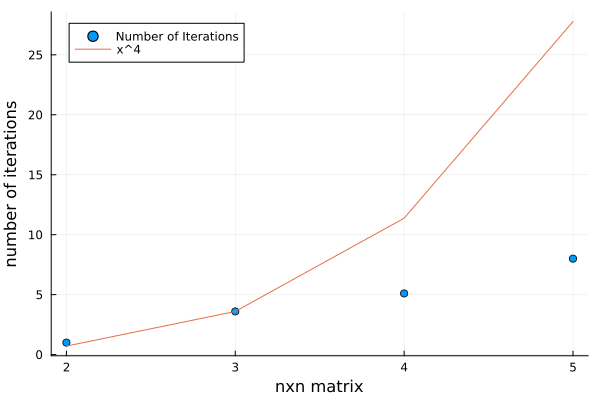

In [12]:
using Plots
plot(o,iterations,seriestype=:scatter,yaxis=:1,label="Number of Iterations")
c=@. iterations[2]*o^4/o[2]^4
plot!(o,c,label="x^4")
xlabel!("nxn matrix")
ylabel!("number of iterations")

In [17]:
numiter([4. 2. 1.5; 5.322 1. 2. ; 5. 8.3 1.])

4

In [46]:
function iters(n::Int64)
    av = []
    mat =[]
    for i in 1:20
        a = rand(n,n)
        t = numiter(a)
        push!(av, t)
        push!(mat,a)
    end
    b=findmax(av)
    println("Full matrix with maximum iterations:")
    show(stdout, "text/plain", mat[b[2]])  # This will print the full matrix
    return av, mean(av), median(av), b[1], b[2]
end

iters (generic function with 1 method)

In [30]:
ENV["LINES"] = 1000  # or a sufficiently large number
ENV["COLUMNS"] = 1000  # or a sufficiently large number

1000

In [47]:
iters(20)

Full matrix with maximum iterations:
20×20 Matrix{Float64}:
 0.484771   0.591275   0.631783   0.238023   0.688687   0.72884   0.0273014  0.460224  0.589369    0.949924   0.266158    0.363435   0.938802   0.183848  0.859711    0.229226  0.338351    0.621248   0.810608   0.860612
 0.109032   0.17035    0.773939   0.0942825  0.416312   0.304533  0.58683    0.935019  0.370751    0.266946   0.463047    0.681938   0.627423   0.455639  0.914885    0.753926  0.796985    0.0405363  0.29118    0.867986
 0.123867   0.647958   0.409445   0.239476   0.0741803  0.544082  0.800204   0.13848   0.416907    0.538699   0.750648    0.642792   0.70013    0.154894  0.296385    0.568708  0.442876    0.622433   0.607368   0.931431
 0.737914   0.200164   0.589644   0.761933   0.885      0.107375  0.0393433  0.467826  0.742246    0.0956097  0.163132    0.829278   0.736166   0.307878  0.709734    0.440764  0.0610903   0.300691   0.201268   0.23107
 0.652592   0.491856   0.601642   0.18274    0.516319   0.989332 

(Any[836, 497, 745, 913, 390, 654, 281, 2297, 432, 603, 498, 413, 416, 559, 383, 426, 562, 5403, 494, 294], 854.8, 497.5, 5403, 18)

In [34]:
function hessfrancisqralg(M::Matrix{Float64})
    #count = 0
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    A = hessen(M, n, ϵ1) #Reduces matrix to hessenberg form
    newA = francisqrdecomp(A, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(A, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newA, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        A = newA #Updates A
        newA = francisqrdecomp(A, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newA, n, ϵ1) #Updates list of eigenvalues of newA
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return newEigen #Returns eigenvalues
end

hessfrancisqralg (generic function with 1 method)

In [35]:
#~118000 iterations
hessfrancisqralg([0.296463  0.674381   0.679824   0.812332   0.881889   0.986923    0.556672  0.390299    0.539757   0.820712  0.365726   0.434133   0.81881    0.351456   0.165416   0.361303    0.616026   0.249901    0.293116    0.592201
 0.168743  0.0208759  0.205564   0.0127404  0.928853   0.46055     0.268949  0.710294    0.687032   0.154635  0.224504   0.667276   0.329172   0.0891307  0.933046   0.764293    0.237413   0.291866    0.69448     0.571379
 0.416068  0.833254   0.0900747  0.149737   0.190843   0.508394    0.648398  0.44624     0.441604   0.605002  0.0362718  0.696787   0.757879   0.199006   0.935637   0.582059    0.919101   0.221777    0.437976    0.363791
 0.58142   0.406054   0.949006   0.234735   0.0253415  0.261652    0.772119  0.414935    0.247247   0.358015  0.558411   0.81718    0.52277    0.572008   0.686868   0.0879429   0.640875   0.0164099   0.957472    0.838418
 0.987338  0.983945   0.069164   0.170719   0.348862   0.693944    0.900531  0.194654    0.948755   0.806019  0.500222   0.0918888  0.754491   0.599371   0.979743   0.43577     0.655211   0.249261    0.259611    0.00332867
 0.14192   0.905892   0.67872    0.525314   0.568772   0.655318    0.457682  0.624325    0.594601   0.565013  0.118209   0.688141   0.757167   0.26141    0.903621   0.394388    0.11588    0.61654     0.735544    0.248893
 0.635078  0.632949   0.683643   0.966116   0.208734   0.6055      0.721519  0.598089    0.0369825  0.565198  0.196712   0.290386   0.580183   0.43011    0.347701   0.566138    0.704702   0.860094    0.121238    0.608429
 0.687194  0.773264   0.920572   0.879799   0.139262   0.820648    0.693413  0.57459     0.352386   0.896096  0.183425   0.4449     0.935186   0.665262   0.908445   0.324714    0.497492   0.669755    0.247527    0.524059
 0.624936  0.554712   0.505242   0.931059   0.501165   0.231313    0.995635  0.258629    0.438382   0.388376  0.301756   0.255287   0.106633   0.627512   0.507138   0.934614    0.699234   0.0717943   0.888477    0.732283
 0.503696  0.131421   0.339429   0.256251   0.494865   0.592329    0.252308  0.411399    0.0590482  0.37088   0.402817   0.330978   0.310831   0.932402   0.0837546  0.410989    0.175881   0.846389    0.876406    0.765222
 0.89797   0.810129   0.874403   0.157876   0.0481192  0.379564    0.651943  0.00941999  0.695469   0.1991    0.445619   0.465661   0.36194    0.664235   0.129842   0.870897    0.976747   0.45057     0.454739    0.518434
 0.636617  0.329923   0.832149   0.146239   0.758636   0.73497     0.54977   0.756761    0.523706   0.05114   0.209253   0.0485441  0.539283   0.534969   0.350346   0.944581    0.0440765  0.747078    0.59723     0.278293
 0.739488  0.956789   0.575643   0.327963   0.230852   0.00277977  0.931424  0.81541     0.115603   0.411484  0.949131   0.344348   0.588836   0.498735   0.945711   0.40904     0.472513   0.00622435  0.443969    0.542101
 0.283982  0.42658    0.249276   0.688168   0.884036   0.448387    0.646566  0.317261    0.299989   0.558926  0.437895   0.999375   0.23308    0.437841   0.881477   0.499145    0.596624   0.472527    0.865154    0.849955
 0.734388  0.999185   0.416865   0.123526   0.45029    0.72224     0.437814  0.77777     0.532014   0.11317   0.653276   0.341935   0.935105   0.313401   0.630135   0.176771    0.30809    0.331144    0.436851    0.36697
 0.630116  0.0311851  0.346015   0.661056   0.338694   0.0336197   0.767081  0.910841    0.860724   0.65903   0.483917   0.548446   0.292599   0.500681   0.808306   0.00932934  0.365731   0.37969     0.42785     0.167514
 0.21655   0.662532   0.718087   0.087261   0.222107   0.776541    0.467836  0.126623    0.726056   0.456507  0.351675   0.729294   0.858067   0.915086   0.76177    0.625624    0.384579   0.622497    0.887788    0.637407
 0.944021  0.248185   0.966989   0.160729   0.466446   0.345727    0.543297  0.0464841   0.69527    0.159038  0.864835   0.211138   0.715356   0.728974   0.521609   0.0287463   0.725799   0.880478    0.00131595  0.280735
 0.682568  0.551174   0.388944   0.476966   0.158354   0.343216    0.188664  0.232748    0.913064   0.32251   0.824918   0.943504   0.0751132  0.985054   0.391193   0.127106    0.447248   0.136576    0.494762    0.0542478
 0.368379  0.21648    0.21033    0.238555   0.933147   0.0400397   0.61427   0.383346    0.728921   0.901831  0.32458    0.4755     0.324758   0.979219   0.268495   0.690166    0.289042   0.890594    0.537919    0.595354])

20-element Vector{ComplexF64}:
    10.051670153887777 + 0.0im
     1.183844645593937 + 0.0im
    1.0324587832529293 + 0.0im
   -0.2909465730756904 - 1.1770513633866573im
   -0.2909465730756905 + 1.1770513633866573im
    0.5717868344008556 + 0.7113712299101003im
    0.5717868344008556 - 0.7113712299101003im
   -1.3995531923482714 + 0.0im
    0.5725416295422534 + 0.0im
 -0.049287769281599954 - 0.8015558260475241im
  -0.04928776928160005 + 0.8015558260475241im
   -0.9293405354702173 + 0.3476057416860213im
   -0.9293405354702173 - 0.3476057416860212im
   -0.6480130910159458 - 0.4737238596192714im
   -0.6480130910159458 + 0.4737238596192714im
   0.03265848433040501 + 0.297025159641218im
  0.032658484330390994 - 0.2970251596412149im
   0.02371673022769133 + 0.0im
   -0.2856027702647866 + 0.13061154977231226im
  -0.28560284295765576 - 0.13061154977097109im

In [ ]:
iters(6)